# Skip Connections in Neural Networks

Skip connections, also known as shortcut connections, are a technique introduced by the ResNet architecture to
address the degradation problem in very deep neural networks.
As the depth of a network increases, the optimization becomes increasingly difficult, and the performance can degrade.

Skip connections provide a way to bypass some layers and allow the input information to propagate more directly to deeper layers. This helps to alleviate the vanishing/exploding gradient problem and enables the training of much deeper networks.

In this notebook, we will explore skip connections using a simple toy example implemented in PyTorch. We will compare the performance of a feedforward neural network with and without skip connections to understand their impact on model performance and training dynamics.

Paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385)


In [1]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Seed for reproducibility
np.random.seed(25)
torch.manual_seed(25)

## Toy dataset

The synthetic dataset consists of a variable number of features and a target variable generated using a series of mathematical operations on the features.
The dataset is designed to be challenging for a simple feedforward neural network to learn. The process is as follows:

1. Initialization: The function generates random data X uniformly distributed between -1 and 1 with the specified number of samples and features.

2. Dynamic Operations: The target variable y is initialized to zeros. For each feature, a series of nonlinear mathematical operations is chosen at random to generate the target variable. The operations include sine, cosine, square, cube, and square root functions. The target variable is generated by applying these operations to the features and adding them to the target variable.

3. Noise: Gaussian noise is added to the target variable to make the dataset more realistic.

In [3]:
def generate_toy_data(
        num_samples: int = 1000,
        num_features: int = 2,
        noise=0.1) -> tuple:
    """
    Generate a non-linear synthetic dataset for binary classification.
    :param num_samples: number of samples to generate
    :param num_features: number of features to generate
    :param noise: amount of noise to add to the data
    :return: a tuple of (features, labels)
    """
    # Define possible transformations. These will be used to generate the labels
    # of the dataset in a non-linear fashion.
    transformations = [
        np.sin,
        np.cos,
        np.exp,
        lambda x: x ** 2, # Square
        lambda x: np.log(x + 1), # Logarithm
        lambda x: x, # Identity
        np.tan, # Tangent
        lambda x: x ** 3, # Cube
        lambda x: x * np.random.uniform(-1, 1),  # Random scaling
        lambda x: np.sqrt(np.abs(x)) # Square root
    ]

    # Generate random data uniformly distributed between -1 and 1
    X = np.random.uniform(-1, 1, (num_samples, num_features))

    # Generate the labels using non-linear functions (sine, cosine, etc.)
    y = np.zeros(num_samples)
    for i in range(num_features):
        transformation = np.random.choice(transformations)
        y += transformation(X[:, i])

    # Add noise to the labels
    y += np.random.normal(0, noise, num_samples)

    return X, y

# Generate the toy dataset
num_samples = 1000
num_features = 10
noise = 0.1
X, y = generate_toy_data(
    num_samples=num_samples,
    num_features=num_features,
    noise=noise
)


Visualize the toy dataset that we will use for this experiment across different dimensions.

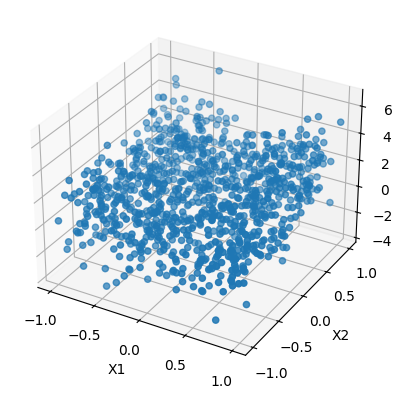

In [4]:
# Visualize the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 6], X[:, 9], y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
plt.show()


In [8]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Show the shape of the training and test sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: torch.Size([800, 10]), y_train shape: torch.Size([800, 1])
X_test shape: torch.Size([200, 10]), y_test shape: torch.Size([200, 1])


## Simple Feedforward Neural Network

We will start by defining a simple feedforward neural network with 3 hidden layers. The network will have 2 hidden layers with ReLU activation functions and one output layer with a sigmoid activation function.

In [9]:
def train_model(
        model: nn.Module,
        X_train: torch.Tensor,
        y_train: torch.Tensor,
        X_test: torch.Tensor,
        y_test: torch.Tensor,
        epochs: int = 1000,
        lr: float = 0.001
    ) -> tuple:
    """
    Train a PyTorch model using the Adam optimizer.
    :param model: the PyTorch model to train
    :param X_train: the training features
    :param y_train: the training labels
    :param X_test: the test features
    :param y_test: the test labels
    :param epochs: the number of epochs to train the model
    :param lr: the learning rate of the optimizer
    :return: a tuple of (train_losses, test_losses)
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return train_losses, test_losses


In [72]:
class SimpleNN(nn.Module):
    def __init__(self, num_features):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Initialize the model
simple_model = SimpleNN(num_features=num_features)

# Train the model
simple_train_losses, simple_test_losses = train_model(
    simple_model,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs=1000,
    lr=0.01
)


Epoch [100/1000], Loss: 0.0644, Test Loss: 0.0914
Epoch [200/1000], Loss: 0.0402, Test Loss: 0.0774
Epoch [300/1000], Loss: 0.0324, Test Loss: 0.0739
Epoch [400/1000], Loss: 0.0281, Test Loss: 0.0739
Epoch [500/1000], Loss: 0.0249, Test Loss: 0.0741
Epoch [600/1000], Loss: 0.0228, Test Loss: 0.0755
Epoch [700/1000], Loss: 0.0216, Test Loss: 0.0749
Epoch [800/1000], Loss: 0.0202, Test Loss: 0.0730
Epoch [900/1000], Loss: 0.0186, Test Loss: 0.0684
Epoch [1000/1000], Loss: 0.0167, Test Loss: 0.0630


In [73]:
# Evaluate the model
simple_model.eval()
with torch.no_grad():
    y_pred = simple_model(X_test)
    mse = F.mse_loss(y_pred, y_test)
    print(f'Mean Squared Error: {mse.item():.4f}')

Mean Squared Error: 0.0630


## Feedforward Neural Network with Skip Connections

We will add skip connections between the input and the output of the network and between the first and the last hidden layer.

**How does a skip connection work?**

It simply adds the input of a layer to the output of another layer. In our case, we will add the input of the network to the output of the last hidden layer and the input of the first hidden layer to the output of the last hidden layer.

In [68]:
class SkipNN(nn.Module):
    def __init__(self, num_features):
        super(SkipNN, self).__init__()
        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        if identity.shape[1] == 64:
            out += identity  # Skip connection
        out = self.fc3(out)
        return out
    
# Initialize the model
skip_model = SkipNN(num_features=num_features)

# Train the model
skip_train_losses, skip_test_losses = train_model(
    skip_model,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs=1000,
    lr=0.01
)

Epoch [100/1000], Loss: 0.0659, Test Loss: 0.0897
Epoch [200/1000], Loss: 0.0466, Test Loss: 0.0691
Epoch [300/1000], Loss: 0.0332, Test Loss: 0.0466
Epoch [400/1000], Loss: 0.0258, Test Loss: 0.0449
Epoch [500/1000], Loss: 0.0233, Test Loss: 0.0461
Epoch [600/1000], Loss: 0.0213, Test Loss: 0.0465
Epoch [700/1000], Loss: 0.0198, Test Loss: 0.0467
Epoch [800/1000], Loss: 0.0187, Test Loss: 0.0477
Epoch [900/1000], Loss: 0.0171, Test Loss: 0.0486
Epoch [1000/1000], Loss: 0.0160, Test Loss: 0.0489


In [69]:
# Evaluate the model
skip_model.eval()
with torch.no_grad():
    y_pred = skip_model(X_test)
    mse = F.mse_loss(y_pred, y_test)
    print(f'Mean Squared Error: {mse.item():.4f}')

Mean Squared Error: 0.0489


## Comparison

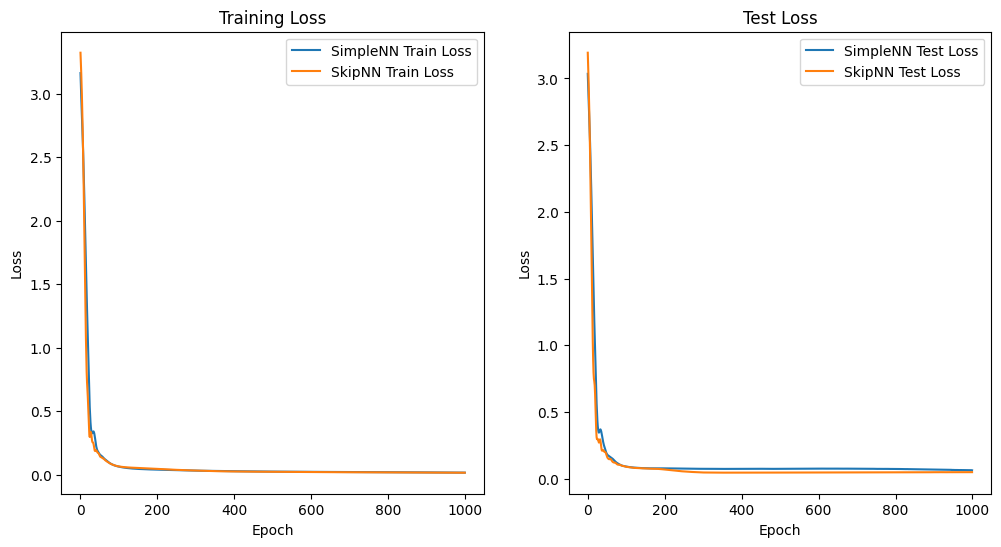

In [74]:
plt.figure(figsize=(12, 6))

# Plot training losses
plt.subplot(1, 2, 1)
plt.plot(simple_train_losses, label='SimpleNN Train Loss')
plt.plot(skip_train_losses, label='SkipNN Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot test losses
plt.subplot(1, 2, 2)
plt.plot(simple_test_losses, label='SimpleNN Test Loss')
plt.plot(skip_test_losses, label='SkipNN Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

plt.show()


## Discussion

The results show that the feedforward neural network with skip connections achieves a lower mean squared error than the network without skip connections (0.0489 vs. 0.0630).
Both networks converge at a similar rate, but this could be due to the simplicity of the dataset and the small number of layers in the network.